### This script is for analyzing the metrics and choosing the optimal feature count.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from collections import Counter
from prettytable import PrettyTable
import os, csv

### First, need to calculate Average Precision for each class in each model.

In [2]:
results_dir = '../LightGBM/results'
df = pd.read_csv('../LightGBM/metrics/report/overall_report.csv')
y_test = pd.read_csv('../data/y_test_id.csv')
label_mapping = {'Neutral': 0, 'GOF': 1, 'LOF': 2}
y_test_numeric = y_test['label'].map(label_mapping).values
y_test_binarized = label_binarize(y_test_numeric, classes=[0, 1, 2])

In [3]:
""" This computes AP score for each class for each model and then merges it into the overall report. """

classes = ['Neutral', 'GOF', 'LOF']
for class_name in classes:
    ap_scores = []
    for model in df['Model']:
        filename = f'lgbm_df{model}.csv'
        filepath = os.path.join(results_dir, filename)
        
        # Load the prediction results from the results directory.
        y_pred_proba = pd.read_csv(filepath)
        
        # Compute AP using SciKit-Learn.
        class_index = classes.index(class_name)
        ap_score = average_precision_score(y_test_binarized[:, class_index], 
                                           y_pred_proba[f'LoGoFunc_{class_name}'])
        ap_scores.append(ap_score)
    
    # Add them to the df.
    df[f'{class_name} AP'] = ap_scores

# Export to new CSV.
df.to_csv('../LightGBM/metrics/report/overall_report_with_ap.csv', index=False)
print("Saved.")

Saved.


In [4]:
""" This is the weighting scheme (detailed in report) that will be used for the final evaluation. """
weight_sets = [
    # Equal weights
    [1/9] * 9,
    
    # GOF emphasis.
    [0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1],
    
    # F1 score emphasis.
    [0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    
    # MCC score emphasis.
    [0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1],
    
    # AP score emphasis.
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2],
    
    # GOF/LOF > Neutral emphasis.
    [0.2, 0.2, 0.1, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1]
]

In [5]:
""" This performs the sensitivity analysis. """

df = pd.read_csv('../LightGBM/metrics/report/overall_report_with_ap.csv')

def weighted_score(metrics, weights):
    """ 
    This computes the weighted score for each metric-weight pair for each class.
    """
    return sum(metric * weight for metric, weight in zip(metrics, weights))

def rank_models(all_model_metrics, weights):
    """ 
    This ranks the models based on the weighted scores.
    """
    scores = []
    for _, model_metrics in all_model_metrics.iterrows():
        metrics = model_metrics[['GOF F1', 'LOF F1', 'Neutral F1', 
                                 'GOF MCC', 'LOF MCC', 'Neutral MCC',
                                 'GOF AP', 'LOF AP', 'Neutral AP']].values
        score = weighted_score(metrics, weights)
        scores.append(score)
    
    ranking = np.argsort(scores)[::-1]
    return ranking, scores

def sensitivity_analysis(df, weight_sets):
    """ 
    This performs the actual sensitivity analysis. 
    """
    results = []
    for weights in weight_sets:
        ranking, scores = rank_models(df, weights)
        top_5 = ranking[:5]
        results.append({
            'weights': weights,
            'top_5_models': top_5,
            'top_5_scores': [scores[i] for i in top_5]
        })
    return results

# Do the sensitivity analysis.
sensitivity_results = sensitivity_analysis(df, weight_sets)
print("\nENS-LGBM Results:")
for i, result in enumerate(sensitivity_results):
    print(f"\nWeight set {i+1}: {result['weights']}")
    print("Top 5 models:")
    for model, score in zip(result['top_5_models'], result['top_5_scores']):
        print(f"Model {df.iloc[model]['Model']}: {score:.4f}")


ENS-LGBM Results:

Weight set 1: [0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
Top 5 models:
Model 414.0: 0.7749
Model 430.0: 0.7747
Model 400.0: 0.7745
Model 433.0: 0.7745
Model 413.0: 0.7743

Weight set 2: [0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1]
Top 5 models:
Model 318.0: 0.8705
Model 430.0: 0.8698
Model 433.0: 0.8696
Model 414.0: 0.8695
Model 400.0: 0.8692

Weight set 3: [0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Top 5 models:
Model 414.0: 0.9354
Model 458.0: 0.9349
Model 430.0: 0.9342
Model 400.0: 0.9341
Model 433.0: 0.9341

Weight set 4: [0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1]
Top 5 models:
Model 414.0: 0.9136
Model 430.0: 0.9125
Model 458.0: 0.9125
Model 400.0: 0.9122
Model 413.0: 0.9118

Weight set 5: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2]
Top 5 models:
Model 318.0: 0.9434
Model 433.0: 0.9425
Model 430.0: 0.9422
Model 400.0

In [6]:
""" This takes the results from the sensitivity analysis and identifies the best model. """

# Looking for consistency across schemes.
all_top_models = [result['top_5_models'] for result in sensitivity_results]
all_top_models = np.concatenate(all_top_models)
model_frequency = Counter(all_top_models)

print("Most frequent top 5:")
for model, freq in model_frequency.most_common(5):
    print(f"Model {df.iloc[model]['Model']:.0f}: {freq} times")

# Each of the six weighting schemes is equally weighted.
scheme_weights = [1/6] * 6

# Compute the weighted average score for each model.
weighted_avg_scores = []
for i in range(len(df)):
    scores = [result['top_5_scores'][np.where(result['top_5_models'] == i)[0][0]] if i in result['top_5_models'] 
              else min(result['top_5_scores']) for result in sensitivity_results]
    weighted_avg_scores.append(np.average(scores, weights=scheme_weights))

top_by_weighted_score = np.argsort(weighted_avg_scores)[::-1][:5]

print("\nTop 5 by weighted avg:")
for i, model_index in enumerate(top_by_weighted_score):
    print(f"{i+1}. Model {df.iloc[model_index]['Model']}: Score {weighted_avg_scores[model_index]:.4f}")

print("\nModel {:.0f} is the most consistent."
      .format(df.iloc[top_by_weighted_score[0]]['Model']))

Most frequent top 5:
Model 430: 6 times
Model 400: 6 times
Model 414: 5 times
Model 433: 5 times
Model 458: 3 times

Top 5 by weighted avg:
1. Model 414.0: Score 0.9272
2. Model 430.0: Score 0.9269
3. Model 318.0: Score 0.9269
4. Model 458.0: Score 0.9267
5. Model 433.0: Score 0.9267

Model 414 is the most consistent.


### Now, calculate and plot ROC AUC curve for the best model.

In [7]:
# Using the results file for the best model identified above.
df = pd.read_csv('../LightGBM/results/lgbm_df414.csv')
y_test = pd.read_csv('../data/y_test_id.csv') 

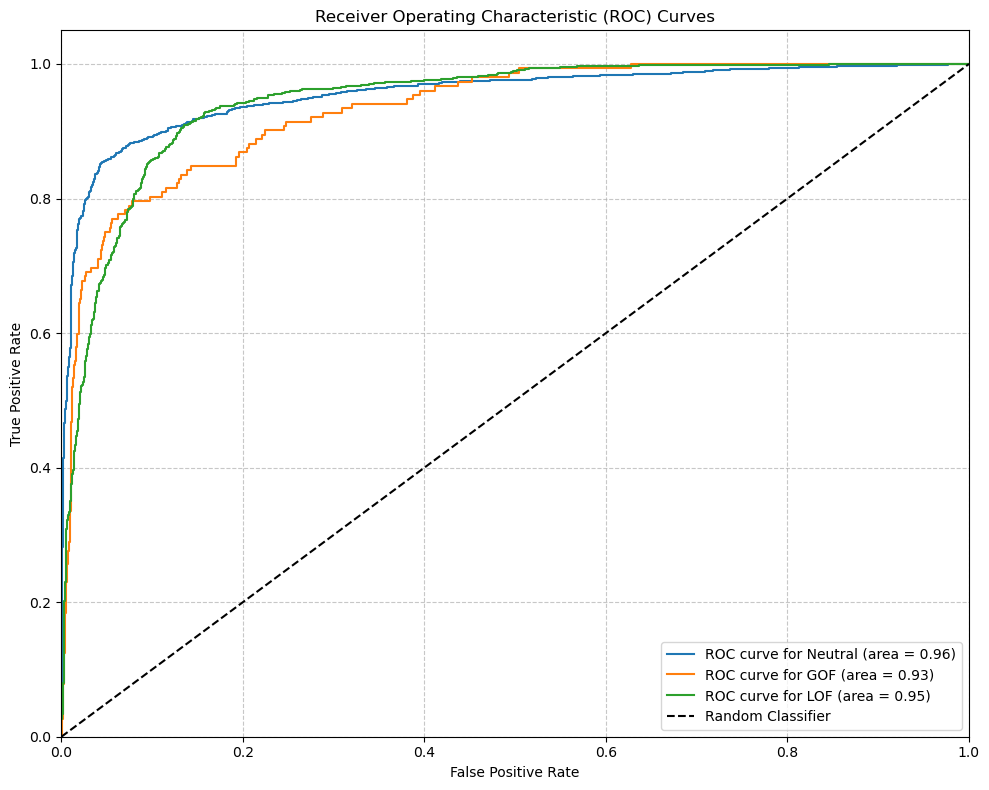

Average AUC: 0.9442


In [8]:
""" Repeated process but with larger plot."""

df = pd.read_csv('../LightGBM/results/lgbm_df414.csv')
y_test = pd.read_csv('../data/y_test_id.csv')

label_mapping = {'Neutral': 0, 'GOF': 1, 'LOF': 2}
y_test_numeric = y_test['label'].map(label_mapping).values
y_pred_proba = df[['LoGoFunc_Neutral', 'LoGoFunc_GOF', 'LoGoFunc_LOF']].values
y_test_binarized = label_binarize(y_test_numeric, classes=[0, 1, 2])

classes = ['Neutral', 'GOF', 'LOF']

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    
    plt.plot(fpr, tpr, label=f'ROC curve for {class_name} (area = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Compute average AUC.
avg_auc = np.mean([roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]) for i in range(3)])
print(f"Average AUC: {avg_auc:.4f}")

### Display all of the data for the top-performing model for my report.

In [9]:
""" Using Pretty Table to display nicely formatted data. """

def tabulate(file_path, model_number):
    with open(file_path, 'r') as csvfile:
        csvreader = csv.DictReader(csvfile)
        for row in csvreader:
            if row['Model'] == str(model_number):
                table = PrettyTable()
                table.field_names = ["Metric", "Value"]
                for key, value in row.items():
                    if key != 'Model':
                        table.add_row([key, value])
                return table
    return None

file_path = '../LightGBM/metrics/report/overall_report_with_ap.csv'
model_number = 414

result = tabulate(file_path, model_number)
print(f"Model {model_number}:")
print(result)

Model 414:
+-------------------+--------------------+
|       Metric      |       Value        |
+-------------------+--------------------+
|   GOF Precision   |        0.51        |
|   LOF Precision   |        0.88        |
| Neutral Precision |        0.92        |
|     GOF Recall    |        0.71        |
|     LOF Recall    |        0.88        |
|   Neutral Recall  |        0.88        |
|    Neutral MCC    |       0.8118       |
|      GOF MCC      |       0.5784       |
|      LOF MCC      |       0.7719       |
|       GOF F1      |        0.6         |
|       LOF F1      |        0.88        |
|     Neutral F1    |        0.9         |
|     Neutral AP    | 0.9578837462859973 |
|       GOF AP      | 0.5425748708002854 |
|       LOF AP      | 0.9316897036768448 |
+-------------------+--------------------+
